<a href="https://colab.research.google.com/github/Vaibhav-sa30/Natural-Language-Processing-using-only-Sklearn-Library/blob/main/NLP_Review_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [161]:
!pip install squarify
!pip install contractions
!pip install opendatasets

In [162]:
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import contractions
#import warnings
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#warnings.filterwarnings("ignore")


In [163]:
dataset_url = 'https://www.kaggle.com/competitions/sentiment-prediction-on-movie-reviews-term-break1'

In [164]:
od.download(dataset_url)

Skipping, found downloaded files in "./sentiment-prediction-on-movie-reviews-term-break1" (use force=True to force download)


In [165]:
data_dir = 'sentiment-prediction-on-movie-reviews-term-break1'

In [166]:
!ls -lh {data_dir}

total 60M
-rw-r--r-- 1 root root  20M Sep 23 00:01  movies.csv
drwxr-xr-x 3 root root 4.0K Sep 23 00:02 'movies.csv (1)'
-rw-r--r-- 1 root root 800K Sep 23 00:01 'sample (1).csv'
-rw-r--r-- 1 root root 9.8M Sep 23 00:01  test.csv
drwxr-xr-x 3 root root 4.0K Sep 23 00:02 'test.csv (1)'
-rw-r--r-- 1 root root  31M Sep 23 00:01  train.csv
drwxr-xr-x 3 root root 4.0K Sep 23 00:02 'train.csv (1)'


Observations:


*   This is a supervised learning classification task
*   The training set has 5 columns
        movieid
        reviewerName
        isFrequentReviewer
        reviewText
        sentiment  (TARGET)

*   Train dataset contains around 163k rows and 5 columns
*   Movies dataset contains around 143k rows and 14 columns
*   Test dataset is the smallest and contains only 55k columns and 4 rows
*   The submission file should contain 'id' and 'sentiment' for each test sample


In [167]:
train = pd.read_csv(data_dir + '/train.csv')
movies = pd.read_csv(data_dir + '/movies.csv')
test = pd.read_csv(data_dir + '/test.csv')

###Train

In [168]:
train.shape

(162758, 5)

In [169]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162758 entries, 0 to 162757
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   movieid             162758 non-null  object
 1   reviewerName        162758 non-null  object
 2   isFrequentReviewer  162758 non-null  bool  
 3   reviewText          156311 non-null  object
 4   sentiment           162758 non-null  object
dtypes: bool(1), object(4)
memory usage: 5.1+ MB


There are missing values in the dataset.

In [170]:
train.isna().sum()

movieid                  0
reviewerName             0
isFrequentReviewer       0
reviewText            6447
sentiment                0
dtype: int64

We can either delete the rows with null values or impute them. It's a belief that if null values are less than 2% of the dataset, then we can safely remove them.

Let's check if removing will affect the analysis.

In [171]:
null_percentage = (train['reviewText'].isnull().sum() / len(train)) * 100

print(f"Percentage of null values in 'reviewText': {null_percentage:.2f}%")

Percentage of null values in 'reviewText': 3.96%


We can see that the null values account to almost 4% of reviewTexts, so we won't remove the null records. Also, later when we'll remove the duplicates, number of records in the dataset is expected to drop very low. And removing null values could lead to significant loss of data too.

In [172]:
train.head()

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
0,marvelous_pirate,Benjamin Henry,False,Henry Selick’s first movie since 2009’s Corali...,POSITIVE
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,Creed II does not give us anything but another...,POSITIVE
3,lara_croft_glimmer,Ryan Barrett,False,"I know what you're thinking, but this is no Li...",POSITIVE
4,jason_bourne_surreal_the_terminator_indiana_jones,Alexander Glover,False,Director Fernando Meirelles tells the story wi...,POSITIVE


In [173]:
train.describe()

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
count,162758,162758,162758,156311,162758
unique,16812,4482,2,155071,2
top,escape_the_terminator_tyler_durden_astonish,Sherri Morrison,False,Parental Content Review,POSITIVE
freq,708,962,113189,29,108761


The train dataset only has categorical columns. Hence, we can't get statistical summary of the data.

Let's explore movies data

###Movie Dataset


In [174]:
movies.shape

(143258, 14)

Now, let's look at other datasets

In [175]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143258 entries, 0 to 143257
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   movieid               143258 non-null  object 
 1   title                 143258 non-null  object 
 2   audienceScore         73248 non-null   float64
 3   rating                13991 non-null   object 
 4   ratingContents        13991 non-null   object 
 5   releaseDateTheaters   30773 non-null   object 
 6   releaseDateStreaming  79420 non-null   object 
 7   runtimeMinutes        129431 non-null  float64
 8   genre                 132175 non-null  object 
 9   originalLanguage      129400 non-null  object 
 10  director              143258 non-null  object 
 11  boxOffice             14743 non-null   object 
 12  distributor           23005 non-null   object 
 13  soundType             15917 non-null   object 
dtypes: float64(2), object(12)
memory usage: 15.3+ MB


In [176]:
movies.isna().sum()

movieid                      0
title                        0
audienceScore            70010
rating                  129267
ratingContents          129267
releaseDateTheaters     112485
releaseDateStreaming     63838
runtimeMinutes           13827
genre                    11083
originalLanguage         13858
director                     0
boxOffice               128515
distributor             120253
soundType               127341
dtype: int64

In [177]:
movies.head()

,movieid,title,audienceScore,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType
0,han_solo_heroic_myth_wonder_woman,Han Solo Heroic Myth Wonder Woman,50.0,NaN,NaN,NaN,2018-08-25,75.0,"Comedy, Horror, Sci-fi",English,Claude Nicolet,NaN,NaN,NaN
1,voyage_tyler_durden_han_solo_stardust,Voyage Tyler Durden Han Solo Stardust,NaN,NaN,NaN,NaN,2020-02-11,114.0,Drama,English,Nathan Haack,NaN,NaN,NaN
2,norman_bates_ferris_bueller_hermione_granger_v...,Norman Bates Ferris Bueller Hermione Granger V...,43.0,NaN,NaN,NaN,NaN,120.0,Drama,Korean,Theresa Smith,NaN,NaN,NaN
3,elegant_hermione_granger,Elegant Hermione Granger,60.0,NaN,NaN,NaN,2020-10-23,90.0,"Action, Mystery & thriller",English,Donald Lewis,NaN,NaN,NaN
4,adventure_rocky_balboa,Adventure Rocky Balboa,70.0,NaN,NaN,NaN,2017-03-27,80.0,"Fantasy, Adventure, Animation",English,Howard Simms,NaN,NaN,NaN


Movies dataset contains both categorical and numerical columns.

In [178]:
movies.describe()

,audienceScore,runtimeMinutes
count,73248.000000,129431.000000
mean,55.674967,93.708578
std,24.553648,28.129175
min,0.000000,1.000000
25%,37.000000,84.000000
50%,57.000000,92.000000
75%,76.000000,103.000000
max,100.000000,2700.000000


The describe function is providing the statistical summary of numerical columns. But if we want to describe the categorical columns, we can use the following command:

In [179]:
movies.describe(include = 'object')

,movieid,title,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,genre,originalLanguage,director,boxOffice,distributor,soundType
count,143258,143258,13991,13991,30773,79420,132175,129400,143258,14743,23005,15917
unique,126404,126404,10,8353,12062,4726,2912,112,62208,4863,3694,551
top,escape_the_terminator_tyler_durden_astonish,Escape The Terminator Tyler Durden Astonish,R,['Language'],2018-09-14,2017-05-22,Drama,English,Joseph Brooks,$1.1M,Paramount Pictures,Surround
freq,367,367,7734,365,37,1232,27860,85034,4194,118,994,4075


###Test Data

In [180]:
test.shape

(55315, 4)

In [181]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55315 entries, 0 to 55314
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   movieid       55315 non-null  object
 1   reviewerName  55315 non-null  object
 2   isTopCritic   55315 non-null  bool  
 3   reviewText    52805 non-null  object
dtypes: bool(1), object(3)
memory usage: 1.3+ MB


In [182]:
test.isna().sum()

movieid            0
reviewerName       0
isTopCritic        0
reviewText      2510
dtype: int64

####Before we make changes to the datasets TRAIN and MOVIES, let's merge them so that we don't have to make the same changes twice and we might even come across features that are contributes to our target variable.

##Merge Train and Movies Datasets

In [183]:
train_merged = pd.merge(train, movies, on = 'movieid', how = 'left')
train_merged.head()

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment,title,audienceScore,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType
0,marvelous_pirate,Benjamin Henry,False,Henry Selick’s first movie since 2009’s Corali...,POSITIVE,Marvelous Pirate,65.0,PG-13,"['Violence', 'Brief Strong Language', 'Substan...",2022-10-21,2022-10-28,105.0,"Comedy, Animation, Adventure, Fantasy",English,Bennie Basso,NaN,Netflix,NaN
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE,Tony Montana Frodo Baggins V Rocky Balboa,NaN,NaN,NaN,NaN,2013-01-08,91.0,Action,English,Alma White,NaN,NaN,NaN
2,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE,Tony Montana Frodo Baggins V Rocky Balboa,47.0,PG-13,"['Some Sexual Material', 'Brief Partial Nudity']",2010-02-12,2010-05-18,119.0,"Holiday, Romance, Comedy, Lgbtq+",English,Hubert Dixon,$110.5M,Warner Bros.,"Dolby Digital, DTS"
3,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,Creed II does not give us anything but another...,POSITIVE,Darth Vader Katniss Everdeen Sorcerer Donnie D...,80.0,PG-13,"['Language', 'A Scene of Sensuality', 'Sports ...",2018-11-21,2019-02-12,130.0,Drama,English,Bobby Oleary,$115.7M,"Warner Bros. Pictures, Metro-Goldwyn-Mayer",NaN
4,lara_croft_glimmer,Ryan Barrett,False,"I know what you're thinking, but this is no Li...",POSITIVE,Lara Croft Glimmer,NaN,NaN,NaN,NaN,2020-06-02,15.0,Drama,Spanish,Eric Hutcherson,NaN,NaN,NaN


In [184]:
train_merged.shape

(525277, 18)

In [185]:
train_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 525277 entries, 0 to 525276
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   movieid               525277 non-null  object 
 1   reviewerName          525277 non-null  object 
 2   isFrequentReviewer    525277 non-null  bool   
 3   reviewText            501460 non-null  object 
 4   sentiment             525277 non-null  object 
 5   title                 525277 non-null  object 
 6   audienceScore         224448 non-null  float64
 7   rating                134486 non-null  object 
 8   ratingContents        134486 non-null  object 
 9   releaseDateTheaters   182326 non-null  object 
 10  releaseDateStreaming  249433 non-null  object 
 11  runtimeMinutes        302589 non-null  float64
 12  genre                 307944 non-null  object 
 13  originalLanguage      304822 non-null  object 
 14  director              525277 non-null  object 
 15  

Observation:


*   `releaseDateTheaters` and `releaseDateStreaming` are in object datatype. However, they need to be in datetime datatype.
*   boxOffice also need to be fixed to correct datatype. That is, numerical.





Let's see how long the data was recorded for. To see that we'll analyze `releaseDateTheaters` and `releaseDateStreaming` columns.

Now, because movies are released first in theaters and then on streaming platform. We'll take the minimum value from `releaseDataTheaters` and maximmum value from `releaseDateStreaming`

But first, we need to convert their datatype to correct datatype (i.e, datetime)

In [186]:
train_merged['releaseDateTheaters'] = pd.to_datetime(train_merged['releaseDateTheaters'], errors='coerce')
train_merged['releaseDateStreaming'] = pd.to_datetime(train_merged['releaseDateStreaming'], errors='coerce')

In [187]:
train_merged['releaseDateTheaters'].min(), train_merged['releaseDateStreaming'].max()

(Timestamp('1903-10-17 00:00:00'), Timestamp('2023-11-17 00:00:00'))

We see something interesting. The data for Streaming is recorded till december of 2023 (This year)

Meaning: Release date of movies in theaters are booked in quite advance. But we see that, even streaming release are booked for some movies.

Let's see for how long the theater release of movies are fixed:

In [188]:
train_merged['releaseDateTheaters'].min(), train_merged['releaseDateTheaters'].max()

(Timestamp('1903-10-17 00:00:00'), Timestamp('2025-02-14 00:00:00'))

We have 122 years worth of data!

###Now, let's how many movies were released per year

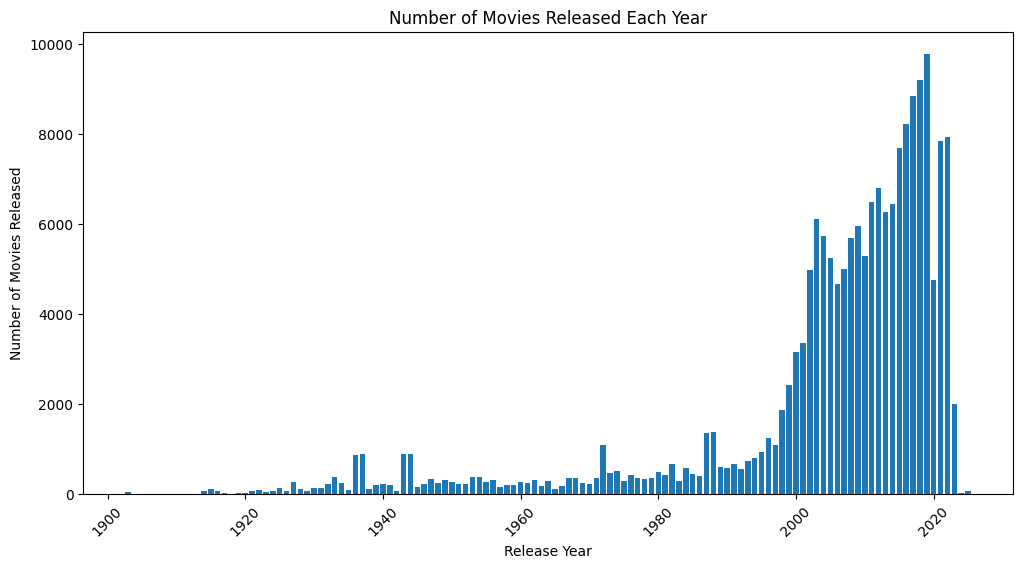

In [189]:
train_merged['theaterReleaseYear'] = train_merged['releaseDateTheaters'].dt.year

# Group the data by release year and count the number of movies released each year
movie_per_year = train_merged['theaterReleaseYear'].value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(movie_per_year.index, movie_per_year.values)

# Add labels and title
plt.xlabel('Release Year')
plt.ylabel('Number of Movies Released')
plt.title('Number of Movies Released Each Year')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.show()

###Number of movies streamed per year

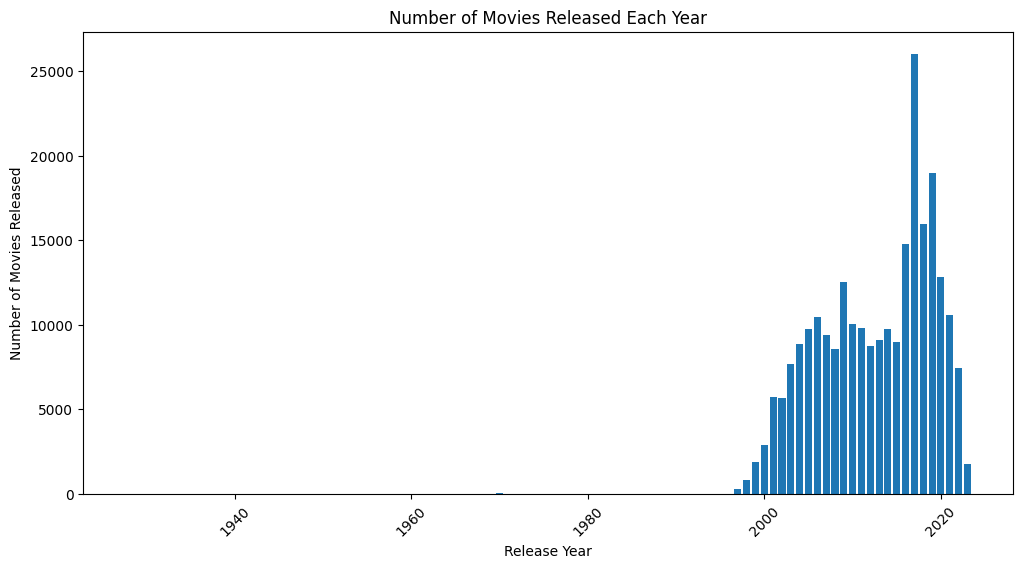

In [190]:
train_merged['streamingReleaseYear'] = train_merged['releaseDateStreaming'].dt.year

# Group the data by release year and count the number of movies released each year
movie_per_year = train_merged['streamingReleaseYear'].value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(movie_per_year.index, movie_per_year.values)

# Add labels and title
plt.xlabel('Release Year')
plt.ylabel('Number of Movies Released')
plt.title('Number of Movies Released Each Year')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.show()

Let's see the box office earning range of movies. But first, we need to fix the datatype of `boxOffice` from object to float64

In [191]:
'''train_merged['boxOffice'] = train_merged['boxOffice'].str.replace('[\$,KM]', '', regex=True)

# Convert the 'boxOffice' column to float
train_merged['boxOffice'] = train_merged['boxOffice'].astype(float)'''

"train_merged['boxOffice'] = train_merged['boxOffice'].str.replace('[\\$,KM]', '', regex=True)\n\n# Convert the 'boxOffice' column to float\ntrain_merged['boxOffice'] = train_merged['boxOffice'].astype(float)"

In [192]:
# Convert the 'boxOffice' column to float
train_merged['boxOffice'] = train_merged['boxOffice'].str.replace('[\$,]', '', regex=True).str.replace('K', 'e3').str.replace('M', 'e6').astype(float)


In [193]:
train_merged['boxOffice'][12]

206400000.0

<ipython-input-194-154572e619a2>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_df['boxOfficeWinsorized'] = movie_df['boxOffice'].clip(lower=lower_bound, upper=upper_bound)


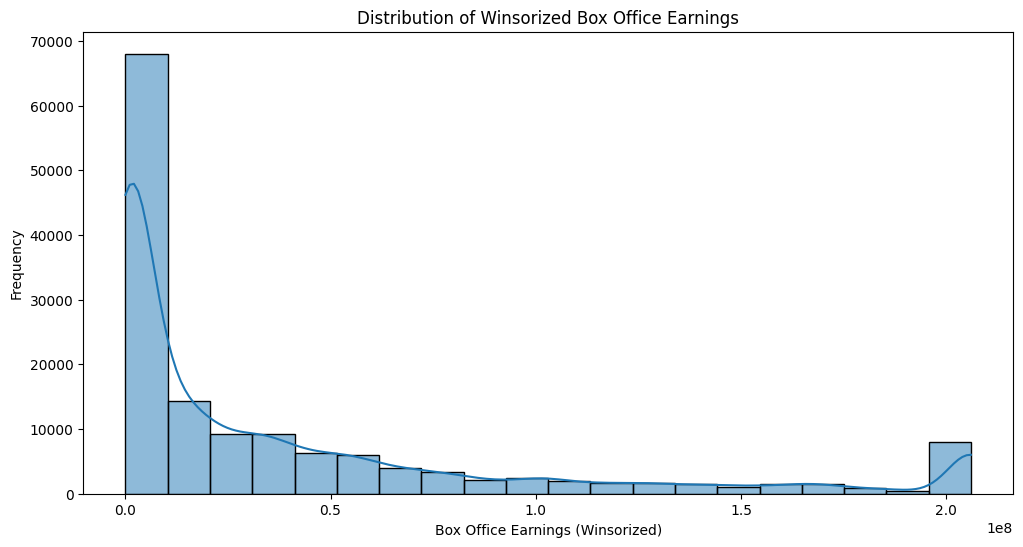

In [194]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Filter out rows with missing box office values
movie_df = train_merged.dropna(subset=['boxOffice'])

# Apply winsorization to 'boxOffice'
lower_bound = movie_df['boxOffice'].quantile(0.05)
upper_bound = movie_df['boxOffice'].quantile(0.95)
movie_df['boxOfficeWinsorized'] = movie_df['boxOffice'].clip(lower=lower_bound, upper=upper_bound)

# Create a histogram to visualize the distribution of box office earnings
plt.figure(figsize=(12, 6))
sns.histplot(movie_df['boxOfficeWinsorized'], bins=20, kde=True)

# Add labels and title
plt.xlabel('Box Office Earnings (Winsorized)')
plt.ylabel('Frequency')
plt.title('Distribution of Winsorized Box Office Earnings')

plt.show();


In [195]:
train_merged.describe()

,audienceScore,runtimeMinutes,boxOffice,theaterReleaseYear,streamingReleaseYear
count,224448.000000,302589.000000,1.450610e+05,182326.000000,249433.000000
mean,63.288659,102.556332,4.728202e+07,2004.902373,2012.595835
std,21.026355,26.051562,8.647324e+07,19.585768,6.316397
min,0.000000,2.000000,0.000000e+00,1903.000000,1928.000000
25%,48.000000,90.000000,6.972000e+05,2002.000000,2007.000000
50%,67.000000,100.000000,1.330000e+07,2011.000000,2014.000000
75%,81.000000,115.000000,5.410000e+07,2017.000000,2018.000000
max,100.000000,561.000000,8.584000e+08,2025.000000,2023.000000


In [196]:
train_merged.drop_duplicates(subset = 'movieid', inplace = True)
train_merged.shape

(16812, 20)

In [197]:
train_merged.isna().sum()

movieid                     0
reviewerName                0
isFrequentReviewer          0
reviewText               1265
sentiment                   0
title                       0
audienceScore            1831
rating                  10676
ratingContents          10676
releaseDateTheaters      5891
releaseDateStreaming     2295
runtimeMinutes            478
genre                     324
originalLanguage          451
director                    0
boxOffice                8453
distributor              6816
soundType               11038
theaterReleaseYear       5891
streamingReleaseYear     2295
dtype: int64

In [198]:
train_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16812 entries, 0 to 525260
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   movieid               16812 non-null  object        
 1   reviewerName          16812 non-null  object        
 2   isFrequentReviewer    16812 non-null  bool          
 3   reviewText            15547 non-null  object        
 4   sentiment             16812 non-null  object        
 5   title                 16812 non-null  object        
 6   audienceScore         14981 non-null  float64       
 7   rating                6136 non-null   object        
 8   ratingContents        6136 non-null   object        
 9   releaseDateTheaters   10921 non-null  datetime64[ns]
 10  releaseDateStreaming  14517 non-null  datetime64[ns]
 11  runtimeMinutes        16334 non-null  float64       
 12  genre                 16488 non-null  object        
 13  originalLanguag

In [199]:
categorical_columns = train_merged.select_dtypes(include=['object']).columns
imputer = SimpleImputer(strategy='most_frequent')
train_merged[categorical_columns] = imputer.fit_transform(train_merged[categorical_columns])

In [200]:
train_merged.isna().sum()

movieid                    0
reviewerName               0
isFrequentReviewer         0
reviewText                 0
sentiment                  0
title                      0
audienceScore           1831
rating                     0
ratingContents             0
releaseDateTheaters     5891
releaseDateStreaming    2295
runtimeMinutes           478
genre                      0
originalLanguage           0
director                   0
boxOffice               8453
distributor                0
soundType                  0
theaterReleaseYear      5891
streamingReleaseYear    2295
dtype: int64

In [201]:
numerical_columns = train_merged.select_dtypes(include=['number']).columns
imputer = SimpleImputer(strategy='mean')
train_merged[numerical_columns] = imputer.fit_transform(train_merged[numerical_columns])

In [202]:
train_merged.isna().sum()

movieid                    0
reviewerName               0
isFrequentReviewer         0
reviewText                 0
sentiment                  0
title                      0
audienceScore              0
rating                     0
ratingContents             0
releaseDateTheaters     5891
releaseDateStreaming    2295
runtimeMinutes             0
genre                      0
originalLanguage           0
director                   0
boxOffice                  0
distributor                0
soundType                  0
theaterReleaseYear         0
streamingReleaseYear       0
dtype: int64

we can remove both the date columns now. No need for it anymore.

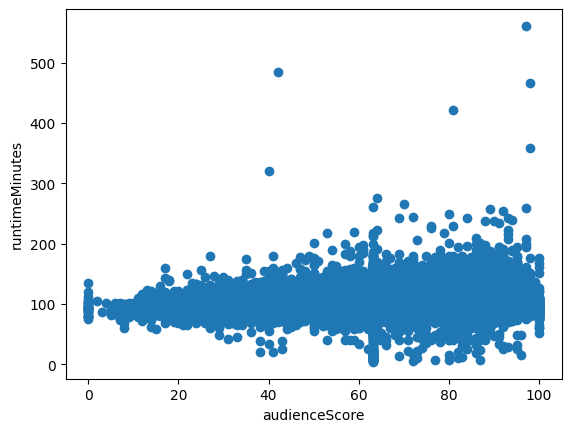

In [203]:
plt.scatter(train_merged['audienceScore'], train_merged['runtimeMinutes'])
plt.xlabel('audienceScore')
plt.ylabel('runtimeMinutes')
plt.show()

In [204]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

train_merged[numerical_columns] = scaler.fit_transform(train_merged[numerical_columns])

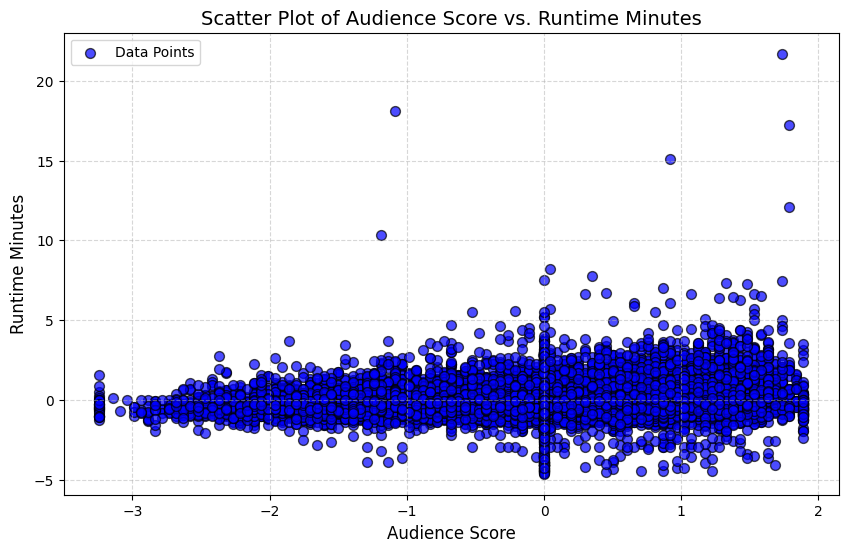

In [205]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.scatter(train_merged['audienceScore'], train_merged['runtimeMinutes'],
            s=50,
            c='blue',
            alpha=0.7,
            edgecolors='black',
            label='Data Points')

plt.xlabel('Audience Score', fontsize=12)
plt.ylabel('Runtime Minutes', fontsize=12)
plt.title('Scatter Plot of Audience Score vs. Runtime Minutes', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

##Corpus Cleaning

Let's take an instance to see how dirty our corpus is. Later, we will be able to compare how much text cleanup we actually did.

In [206]:
train_merged['reviewText'][180]

"Look, it's easy to laugh at this stuff - that's part of the game, in fact. To buy into these movies, you have to buy into the silliness. But The Longest Ride, for all its ridiculousness, comes by its emotions honestly."

In [207]:

def expand_contractions(text):
    # Implement your own function to expand contractions here
    # Example implementation using a contraction mapping dictionary:
    contraction_mapping = {
        "ain't": "am not",
        "aren't": "are not",
        "can't": "cannot",
        "could've": "could have",
        "aren’t" : "are not" ,
        "there’s": "there is" ,
        "can’t" : "can not" ,
        "they’d" : "they had",
        "couldn’t" : "could not" ,
        "they’ll" : "they will",
        "didn’t" : "did not" ,
        "they’re" : "they are",
        "doesn’t" : "does not" ,
        "they’ve" : "they have",
        "don’t" : "do not" ,
        "we’d" : "we had",
        "hadn’t" : "had not" ,
        "we’re" : "we are",
        "hasn’t" : "has not" ,
        "we’ve" : "we have",
        "haven’t" : "have not" ,
        "weren’t" : "were not",
        "he’d" : "he had",
        "what’ll" : "what will",
        "he’ll" : "he will",
        "what’re" : "what are",
        "he’s" : "he is",
        "what’s" : "what is",
        "I’d" : "I had",
        "what’ve" : "what have",
        "I’ll" : "I will",
        "where’s" : "where is",
        "I’m" : "I am" ,
        "who’d" : "who had",
        "I’ve" : "I have" ,
        "who’ll" : "who will",
        "isn’t" : "is not" ,
        "who’re" : "who are",
        "let’s" : "let us" ,
        "who’s" : "who is",
        "mightn’t" : "might not" ,
        "who’ve" : "who have",
        "mustn’t" : "must not" ,
        "won’t" : "will not",
        "shan’t" : "shall not" ,
        "wouldn’t" : "would not",
        "she’d" : "she had",
        "you’d" : "you had",
        "she’ll" : "she will",
        "you’ll" : "you will",
        "she’s" : "she is",
        "you’re" : "you are",
        "shouldn’t" : "should not",
        "you’ve" : "you have",
        "that’s" : "that is",
    }
    for contraction, expansion in contraction_mapping.items():
        text = text.replace(contraction, expansion)
    return text

def eliminate_apostrophes(text):
    text = text.replace("'", "")
    return text

def eliminate_numbers(text):
    text = re.sub(r"\d+", "", text)
    return text

def eliminate_special_characters(text):
    special_characters = string.punctuation.replace("'", "")
    text = re.sub(rf"[{re.escape(special_characters)}]", "", text)
    return text

def remove_stopwords(text):
    stop_words = set(ENGLISH_STOP_WORDS)
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    text = " ".join(filtered_words)
    return text

#preprocessing function

def preprocess_text(text):
    text = expand_contractions(text)
    text = eliminate_apostrophes(text)
    text = eliminate_numbers(text)
    text = eliminate_special_characters(text)
    text = text.lower()

    # Step 6: Tokenization (optional, depending on subsequent steps)
    # Skip tokenization for now

    # Step 7: Stopword Removal
    text = remove_stopwords(text)

    return text

cleaned_text = train_merged.copy()
cleaned_text['reviewText'] = train_merged['reviewText'].apply(preprocess_text)

SO, How much cleanup did we do?

In [208]:
train_merged['reviewText'][180]

"Look, it's easy to laugh at this stuff - that's part of the game, in fact. To buy into these movies, you have to buy into the silliness. But The Longest Ride, for all its ridiculousness, comes by its emotions honestly."

In [209]:
cleaned_text['reviewText'][180]

'look easy laugh stuff thats game fact buy movies buy silliness longest ride ridiculousness comes emotions honestly'

How many words we lose?

In [210]:
all_uncleaned_words = []
for t in train_merged['reviewText']:
    if isinstance(t, str):
        all_uncleaned_words.extend(t.split())

#print("All Uncleaned Words:\n\n", all_uncleaned_words[:50])
print("\n\nTotal Number of Words Before Cleaning:", len(all_uncleaned_words))



Total Number of Words Before Cleaning: 336801


In [211]:
all_cleaned_words = []
for t in cleaned_text['reviewText']:
    if isinstance(t, str):
        all_cleaned_words.extend(t.split())

#print("All Uncleaned Words:\n\n",all_cleaned_words[:50])
print("\n\nTotal Number of Words After Cleaning:",len(all_cleaned_words))



Total Number of Words After Cleaning: 175402


Observation: The number of words dropped from 336k to 175k. Which is a significant drop.

\\

####Why are we bothered about this number?

Size of vocab will determine the size of features. We know, that each word of the vocab can be considered as a feature.

This vocab of 175k words will be used to make the corpus structured.

###Top 25 Cleaned Words

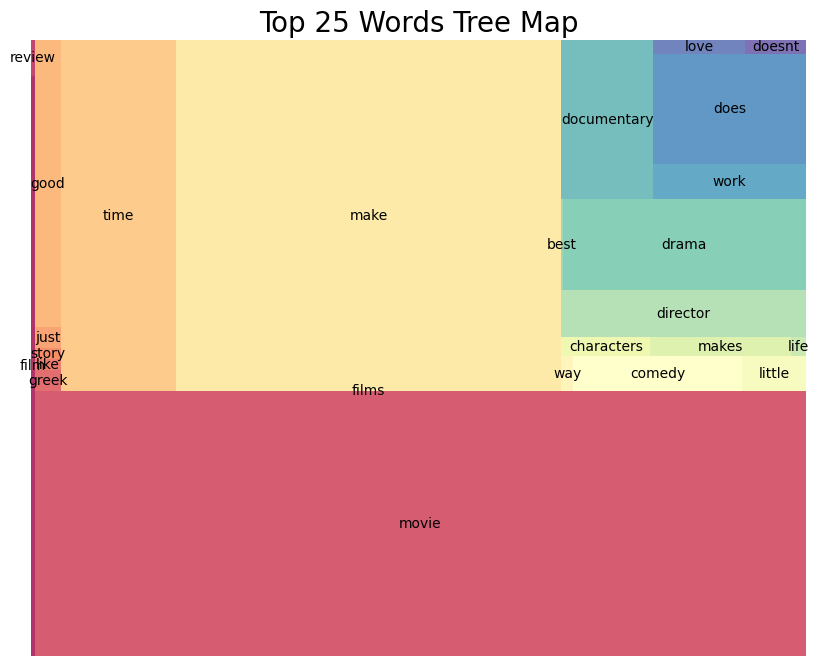

In [212]:
import squarify
from collections import Counter

word_counts = Counter(all_cleaned_words)

words = list(word_counts.keys())
frequencies = list(word_counts.values())

sorted_words = [x for _, x in sorted(zip(frequencies, words), reverse=True)]

top_25_words = sorted_words[:25]
top_frequencies = frequencies[:25]

labels = top_25_words
sizes = top_frequencies

colors = plt.cm.Spectral(np.linspace(0, 1, len(labels)))

squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8)

plt.title('Top 25 Words Tree Map', fontsize=20)
plt.axis('off')
plt.gcf().set_size_inches(10, 8)

plt.show()

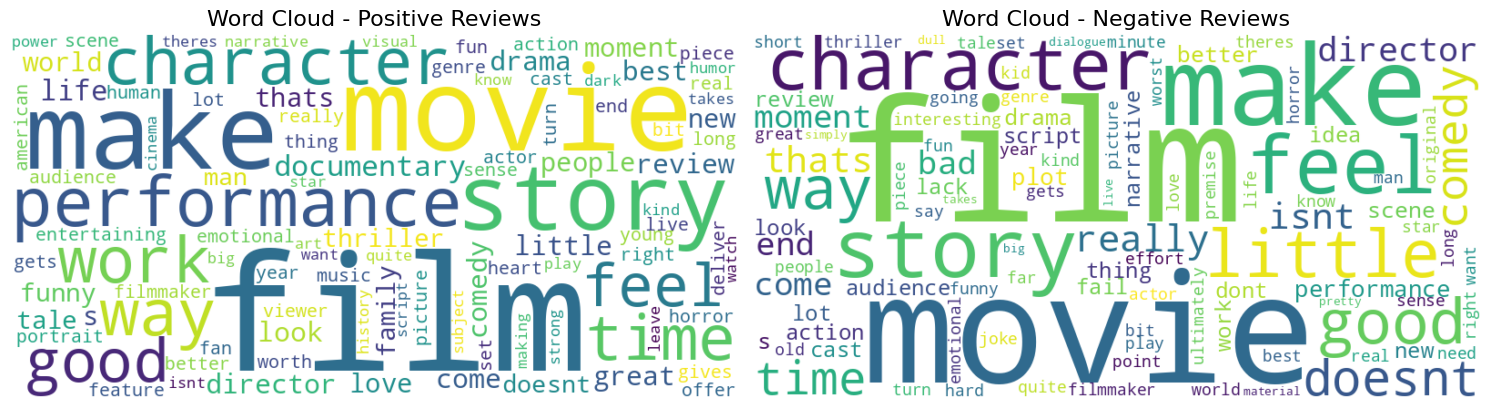

In [213]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud_params = {
    'width': 800,
    'height': 400,
    'background_color': 'white',
    'colormap': 'viridis',
    'max_words': 100,
    'contour_width': 1,
    'contour_color': 'steelblue',
}

cleaned_text['sentiment'] = cleaned_text['sentiment'].str.lower()

negative_reviews = cleaned_text[cleaned_text['sentiment'] == 'negative']
positive_reviews = cleaned_text[cleaned_text['sentiment'] == 'positive']

positive_text = "".join(positive_reviews['reviewText'])

negative_text = "".join(negative_reviews['reviewText'])

wordcloud_positive = WordCloud(**wordcloud_params).generate(positive_text)

wordcloud_negative = WordCloud(**wordcloud_params).generate(negative_text)

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

axes[0].imshow(wordcloud_positive, interpolation='bilinear')
axes[0].set_title('Word Cloud - Positive Reviews', fontsize=16)
axes[0].axis('off')

axes[1].imshow(wordcloud_negative, interpolation='bilinear')
axes[1].set_title('Word Cloud - Negative Reviews', fontsize=16)
axes[1].axis('off')

plt.tight_layout()
plt.show()

We notice, that in either of the classes, there are fews domain specific words that are most prevailing. Which is making it hard to infer about positive or negative reviews.

We want to remove these domain specific stop words too.

######Collect list of domain specific stop words

In [214]:
domain_stop_words = set([
    'movie', 'film', 'movies', 'films', 'actor', 'actress', 'directed',
    'director', 'cinema', 'scene', 'scenes', 'screenplay', 'screen',
    'story', 'plot', 'character', 'characters', 'role', 'roles', 'act',
    'acting', 'genre', 'genres', 'hollywood', 'review', 'reviews',
    'critic', 'critics', 'award', 'awards', 'best', 'worst', 'good',
    'bad', 'great', 'poor', 'entertainment', 'script', 'director',
    'oscar', 'nominated', 'performance', 'screen', 'theater', 'scene',
    'scenes', 'sequel', 'cast', 'production', 'hollywood', 'festival',
    'watched', 'watching', 'viewer', 'audience', 'screening', 'release',
    'released', 'premiere', 'premiered', 'entertaining', 'entertainment',
    'starring', 'camera', 'viewer', 'plotline', 'box office', 'soundtrack',
    'sound', 'musical', 'musicals', 'cinematography', 'flop', 'hit',
    'adaptation', 'adapted', 'blockbuster', 'villain', 'hero', 'heroine',
    'narrative', 'dialogue', 'filmmaker', 'filmmaking', 'award-winning',
    'storyline', 'genre', 'cinematic', 'screenwriter', 'scriptwriter',
    'backdrop', 'motion picture', 'silver screen', 'on-screen', 'big screen',
    'in theaters', 'oscar-worthy', "viewer's choice", 'screen presence',
    'picture', 'opening credits', 'closing credits', 'coming attraction',
    "director's cut", 'filmography', 'leading role', 'supporting role',
    'motion picture industry', 'box office hit', 'cult film', 'mainstream',
    'cinematic experience', 'leading man', 'leading lady', 'independent film',
    'documentary', 'animated film', 'on location', 'voice-over', 'animation',
    'film industry', 'motion picture', 'scene-stealer', 'plot twist',
    'suspense', 'cinematic masterpiece', 'moviegoer', 'scene-chewing',
    'viewer discretion', 'sound effects', 'in production', 'post-production',
    'film festival', 'motion picture studio', 'filming locations',
    'production crew', 'directorial debut', 'motion picture soundtrack',
    'cinematographic', 'costume design', 'movie magic', 'directorial vision',
    'film buff', 'on-screen chemistry', 'casting call', 'cinematic history',
    'film critic', 'camera angle', 'motion picture director', 'on-screen love',
    'film noir', 'scene direction', 'camera operator', 'screenplay writer',
    'big screen debut', 'film industry insider', 'film lover', 'motion picture'
])


######Collect list of common adjectives

In [215]:
adjectives = [
    "attractive", "bald", "beautiful", "chubby", "clean", "dazzling", "drab",
    "elegant", "fancy", "fit", "flabby", "glamorous", "gorgeous", "handsome",
    "long", "magnificent", "muscular", "plain", "plump", "quaint", "scruffy",
    "shapely", "short", "skinny", "stocky", "ugly", "unkempt", "unsightly",
    "alive", "better", "careful", "clever", "dead", "easy", "famous", "gifted",
    "hallowed", "helpful", "important", "inexpensive", "mealy", "mushy", "odd",
    "poor", "powerful", "rich", "shy", "tender", "unimportant", "uninterested",
    "vast", "wrong", "aggressive", "agreeable", "ambitious", "brave", "calm",
    "delightful", "eager", "faithful", "gentle", "happy", "jolly", "kind",
    "lively", "nice", "obedient", "polite", "proud", "silly", "thankful",
    "victorious", "witty", "wonderful", "zealous",
    "angry", "bewildered", "clumsy", "defeated", "embarrassed", "fierce", "grumpy",
    "helpless", "itchy", "jealous", "lazy", "mysterious", "nervous", "obnoxious",
    "panicky", "pitiful", "repulsive", "scary", "thoughtless", "uptight", "worried",
    "broad", "crooked", "curved", "deep", "flat", "high", "hollow", "low",
    "narrow", "refined", "round", "shallow", "square", "steep", "straight",
    "wide",
    "big", "colossal", "fat", "gigantic", "great", "huge", "immense", "large",
    "little", "mammoth", "massive", "microscopic", "miniature", "petite", "puny",
    "scrawny", "short", "small", "tall", "teeny", "tiny",
    "crashing", "deafening", "echoing", "faint", "harsh", "hissing", "howling",
    "loud", "melodic", "noisy", "purring", "quiet", "rapping", "raspy",
    "rhythmic", "screeching", "shrilling", "squeaking", "thundering", "tinkling",
    "wailing", "whining", "whispering",
    "ancient", "brief", "early", "fast", "future", "late", "long", "modern",
    "old", "old-fashioned", "prehistoric", "quick", "rapid", "short", "slow",
    "swift", "young",
    "acidic", "bitter", "cool", "creamy", "delicious", "disgusting", "fresh",
    "greasy", "juicy", "hot", "moldy", "nutritious", "nutty", "putrid", "rancid",
    "ripe", "rotten", "salty", "savory", "sour", "spicy", "spoiled", "stale",
    "sweet", "tangy", "tart", "tasteless", "tasty", "yummy",
    "breezy", "bumpy", "chilly", "cold", "cool", "cuddly", "damaged", "damp",
    "dirty", "dry", "flaky", "fluffy", "freezing", "greasy", "hot", "icy",
    "loose", "melted", "prickly", "rough", "shaggy", "sharp", "slimy", "sticky",
    "strong", "tight", "uneven", "warm", "weak", "wet", "wooden",
    "abundant", "billions", "enough", "few", "full", "hundreds", "incalculable",
    "limited", "little", "many", "most", "millions", "numerous", "scarce",
    "some", "sparse", "substantial", "thousands",]


#####Positve Word Cloud

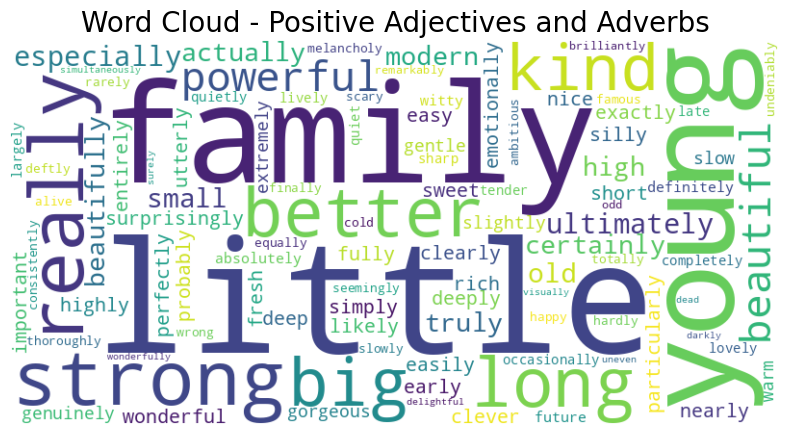

In [216]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import string

def is_adjective_or_adverb(word):
    return word.endswith("ly") or word in adjectives


positive_tokens = positive_text.lower().split()
filtered_positive_tokens = [word for word in positive_tokens if word not in domain_stop_words]

adjectives_and_adverbs_positive = [word for word in filtered_positive_tokens if is_adjective_or_adverb(word)]

filtered_adjectives_and_adverbs_positive_text = " ".join(adjectives_and_adverbs_positive)

wordcloud_adjectives_and_adverbs_positive = WordCloud(**wordcloud_params).generate(filtered_adjectives_and_adverbs_positive_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_adjectives_and_adverbs_positive, interpolation='bilinear')
plt.title('Word Cloud - Positive Adjectives and Adverbs', fontsize=20)
plt.axis('off')
plt.show()


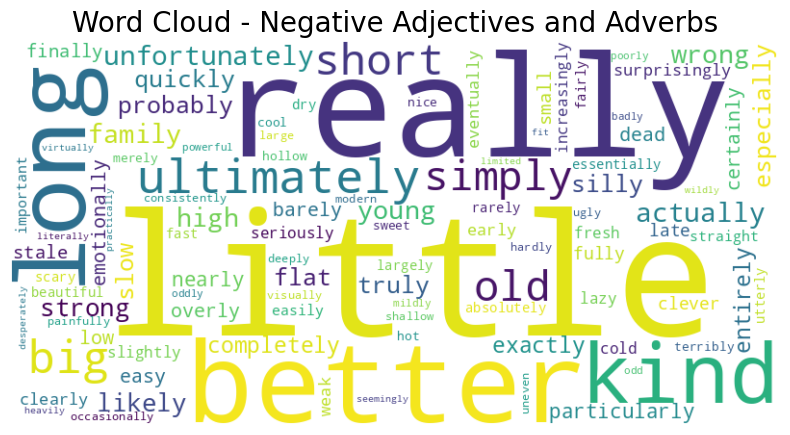

In [217]:
from numpy.ma.core import negative

negative_tokens = negative_text.lower().split()
filtered_negative_tokens = [word for word in negative_tokens if word not in domain_stop_words]

adjectives_and_adverbs_negative = [word for word in filtered_negative_tokens if is_adjective_or_adverb(word)]

filtered_adjectives_and_adverbs_negative_text = " ".join(adjectives_and_adverbs_negative)

wordcloud_adjectives_and_adverbs_negative = WordCloud(**wordcloud_params).generate(filtered_adjectives_and_adverbs_negative_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_adjectives_and_adverbs_negative, interpolation='bilinear')
plt.title('Word Cloud - Negative Adjectives and Adverbs', fontsize=20)
plt.axis('off')
plt.show()

###Check for Class Imbalance in Sentiment Attribute

In [218]:
import seaborn as sns

sentiment_counts = cleaned_text['sentiment'].value_counts()

sentiment_counts


positive    11160
negative     5652
Name: sentiment, dtype: int64

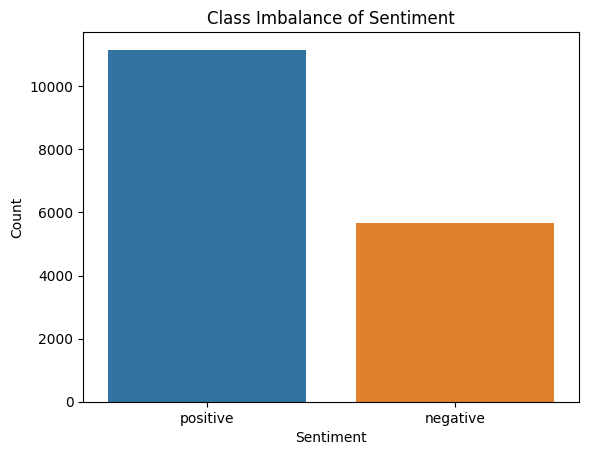

In [219]:
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Class Imbalance of Sentiment')
plt.show()

As we can see, the negative reviews are nearly half the number of positive reviews. This amount of imbalance is tolerable.

###Top 10 Reviewers

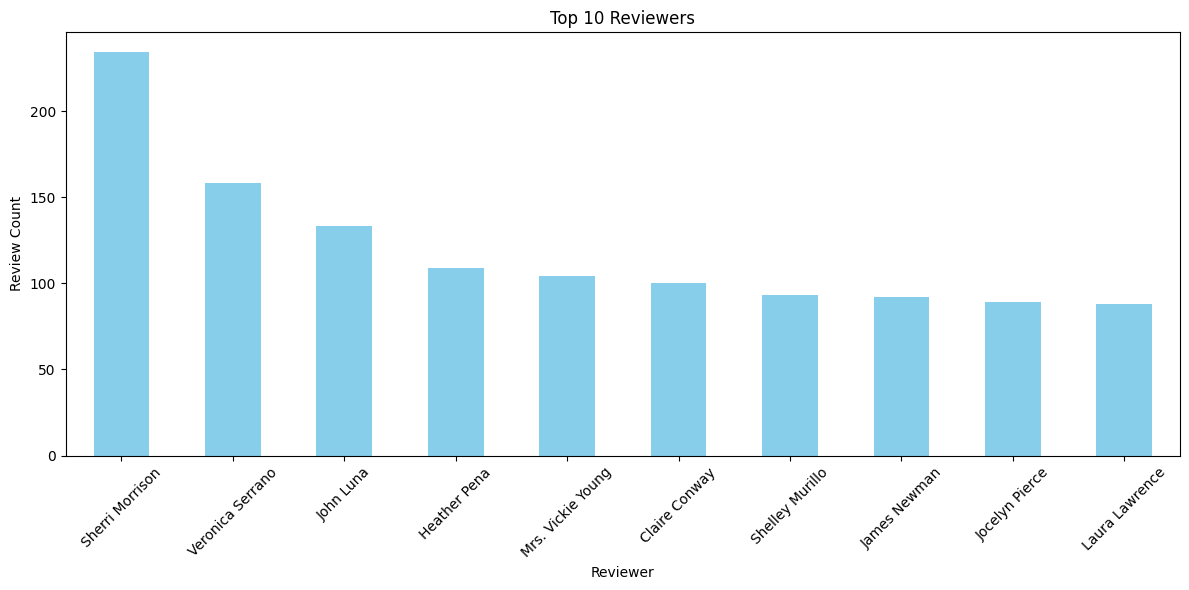

In [220]:
import matplotlib.pyplot as plt

top_reviewers = cleaned_text['reviewerName'].value_counts().head(10)

plt.figure(figsize=(12, 6))
top_reviewers.plot(kind='bar', color='skyblue')
plt.xlabel('Reviewer')
plt.ylabel('Review Count')
plt.title('Top 10 Reviewers')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


###Top 10 Distributors

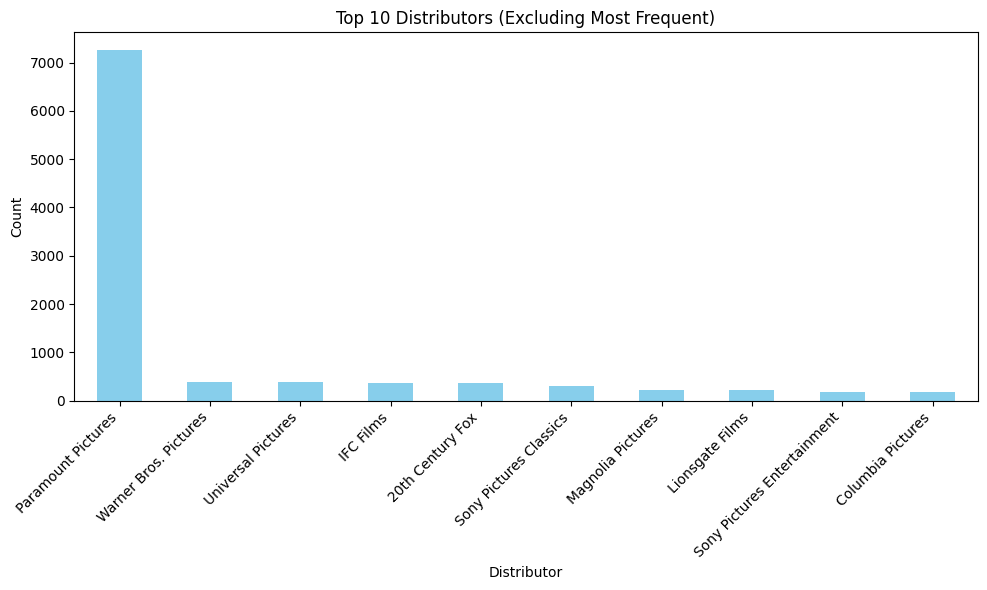

In [221]:
import pandas as pd
import matplotlib.pyplot as plt

distributor_counts = train_merged['distributor'].value_counts()

top_n = 10

top_distributors = distributor_counts.head(top_n)

plt.figure(figsize=(10, 6))
top_distributors.plot(kind='bar', color='skyblue')

plt.title(f'Top {top_n} Distributors (Excluding Most Frequent)')
plt.xlabel('Distributor')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

###Top 10 Genres

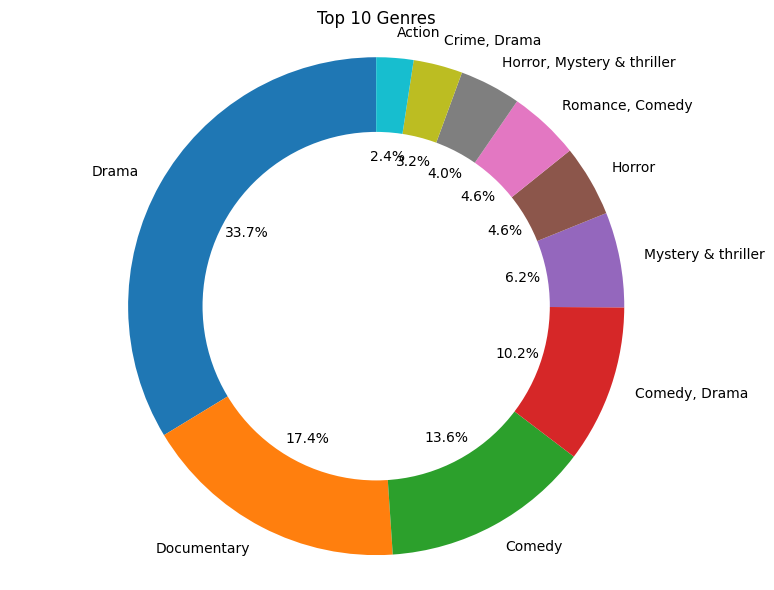

In [222]:
import pandas as pd
import matplotlib.pyplot as plt
genre_counts = train_merged['genre'].value_counts()

top_n = 10

fig, ax = plt.subplots(figsize=(8, 6))

ax.pie(genre_counts.head(top_n), labels=genre_counts.index[:top_n], autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.4))

center_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(center_circle)

plt.title(f'Top {top_n} Genres')
plt.axis('equal')

plt.tight_layout()
plt.show()

###Top 10 languages

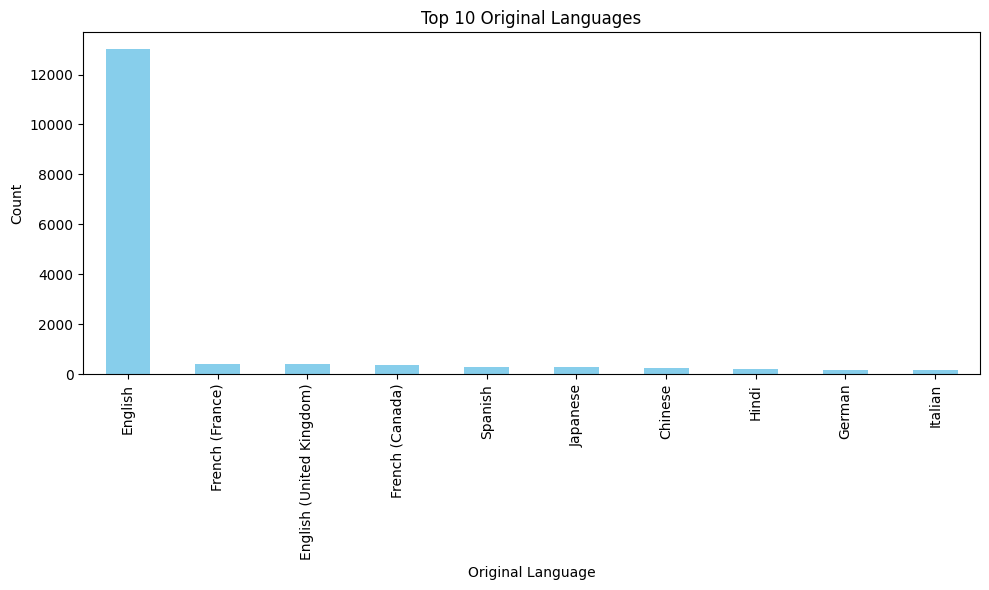

In [223]:
import pandas as pd
import matplotlib.pyplot as plt

language_counts = train_merged['originalLanguage'].value_counts()

top_n = 10

plt.figure(figsize=(10, 6))
language_counts.head(top_n).plot(kind='bar', color='skyblue')

plt.title(f'Top {top_n} Original Languages')
plt.xlabel('Original Language')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


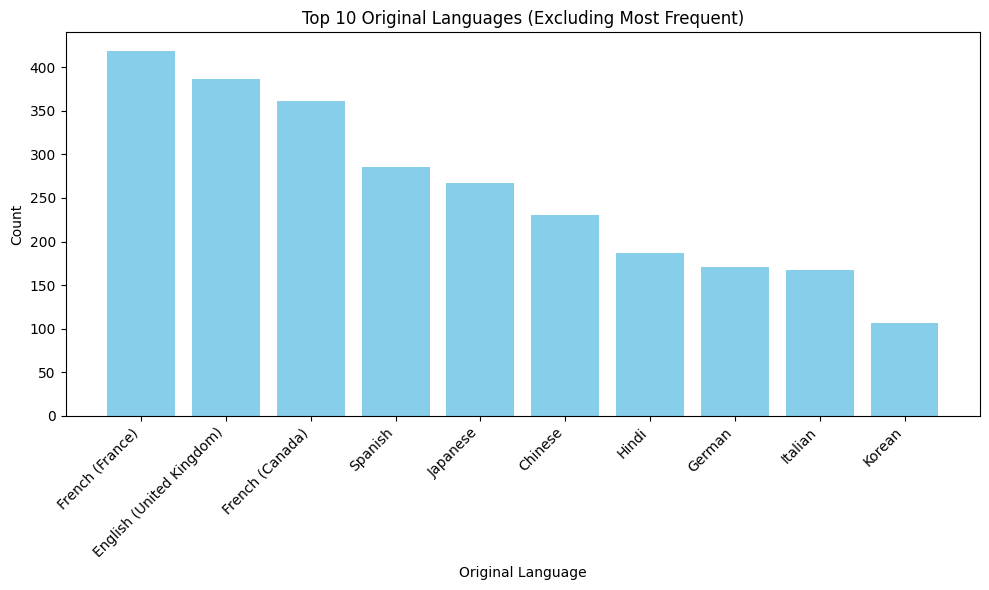

In [224]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have your data loaded in a DataFrame called 'merged_df'

# Count the occurrences of each original language and sort them in descending order
language_counts = train_merged['originalLanguage'].value_counts()

# Set the number of top languages you want to plot excluding the most frequent one (e.g., top 11)
top_n = 11

# Exclude the most frequent language
top_languages = language_counts.index[1:top_n]
top_language_counts = language_counts.values[1:top_n]

# Create a bar plot for the top languages
plt.figure(figsize=(10, 6))
plt.bar(top_languages, top_language_counts, color='skyblue')

# Customize the plot
plt.title(f'Top {top_n - 1} Original Languages (Excluding Most Frequent)')
plt.xlabel('Original Language')
plt.ylabel('Count')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()


The number of hindi movies are little less than 200. Which is crazy low number out of 16k movies, considering the number of movies bollywood produces each year.

###Correlation matrix of numerical columns



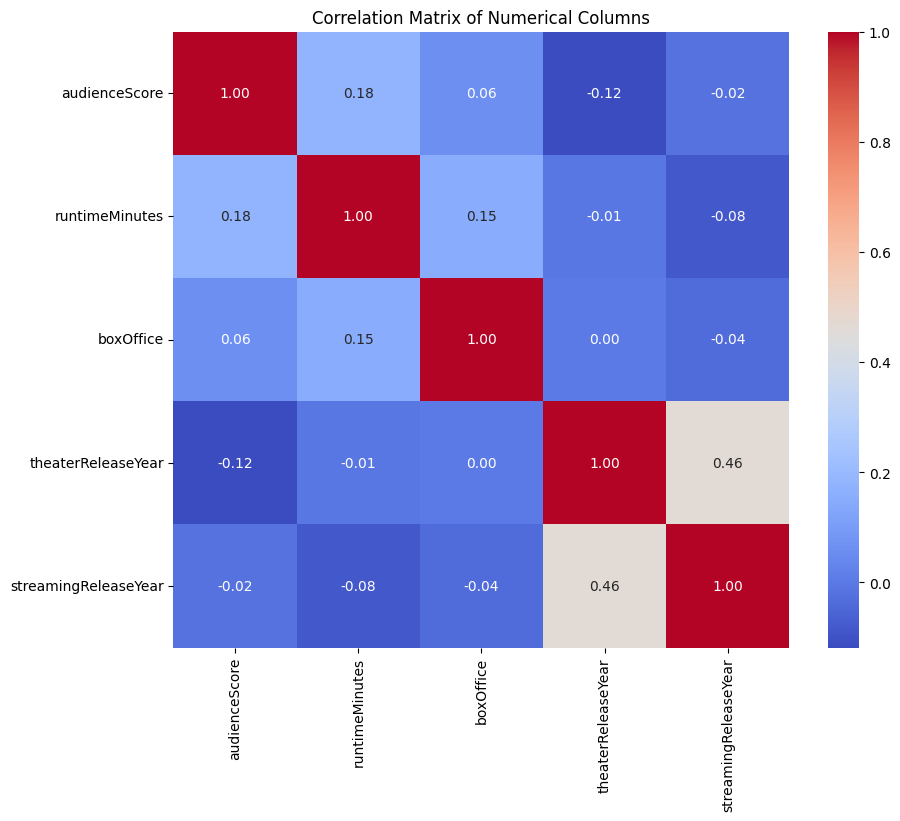

In [225]:
numerical_columns = ['audienceScore', 'runtimeMinutes', 'boxOffice', 'theaterReleaseYear', 'streamingReleaseYear']
correlation_matrix = cleaned_text[numerical_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix of Numerical Columns")
plt.show()

In [226]:
cleaned_text.head()

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment,title,audienceScore,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType,theaterReleaseYear,streamingReleaseYear
0,marvelous_pirate,Benjamin Henry,False,henry selick’s movie ’s coraline fifth stopmot...,positive,Marvelous Pirate,9.345232e-02,PG-13,"['Violence', 'Brief Strong Language', 'Substan...",2022-10-21,2022-10-28,0.145100,"Comedy, Animation, Adventure, Fantasy",English,Bennie Basso,0.000000,Netflix,Surround,1.199735e+00,1.632569
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,cast reads like vogue oscar party guest list v...,negative,Tony Montana Frodo Baggins V Rocky Balboa,-3.648511e-16,R,['Language'],NaT,2013-01-08,-0.516653,Action,English,Alma White,0.000000,Paramount Pictures,Surround,2.990949e-14,0.179928
3,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,creed ii does slightly superior rocky sequel w...,positive,Darth Vader Katniss Everdeen Sorcerer Donnie D...,8.636756e-01,PG-13,"['Language', 'A Scene of Sensuality', 'Sports ...",2018-11-21,2019-02-12,1.326803,Drama,English,Bobby Oleary,2.245004,"Warner Bros. Pictures, Metro-Goldwyn-Mayer",Surround,9.366486e-01,1.148355
4,lara_croft_glimmer,Ryan Barrett,False,know youre thinking limitless bradley cooper c...,positive,Lara Croft Glimmer,-3.648511e-16,R,['Language'],NaT,2020-06-02,-4.109028,Drama,Spanish,Eric Hutcherson,0.000000,Paramount Pictures,Surround,2.990949e-14,1.309760
8,jason_bourne_surreal_the_terminator_indiana_jones,Alexander Glover,False,director fernando meirelles tells story urgenc...,positive,Jason Bourne Surreal The Terminator Indiana Jones,1.736595e+00,R,"['Language', 'Drug Content', 'Sexuality', 'Str...",2003-01-17,2004-06-08,1.374071,"Crime, Drama",Portuguese (Brazil),John Trent,-0.440581,Miramax Films,"Surround, Dolby SR, Dolby Digital, Dolby A, Do...",-4.992649e-02,-1.272713


In [ ]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,  # Maximum number of features (words) to include in the TF-IDF matrix
    stop_words='english',  # Remove common English stop words
    lowercase=True,  # Convert all text to lowercase
    ngram_range=(1, 2),  # Consider both unigrams and bigrams
)

reviewText_matrix = tfidf_vectorizer.fit_transform(cleaned_text['reviewText'])
reviewText_array = reviewText_matrix.toarray()

In [240]:
reviewText_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [228]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Perform label encoding for 'isFrequentReviewer'
cleaned_text['isFrequentReviewer'] = label_encoder.fit_transform(cleaned_text['isFrequentReviewer'])

# Perform label encoding for 'sentiment'
cleaned_text['sentiment'] = label_encoder.fit_transform(cleaned_text['sentiment'])

# Display the updated DataFrame
cleaned_text[['isFrequentReviewer', 'sentiment']]


,isFrequentReviewer,sentiment
0,0,1
1,0,0
3,1,1
4,0,1
8,0,1
...,...,...
523655,0,0
524105,0,1
524147,0,0
524794,0,1


In [229]:
cleaned_text.head()

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment,title,audienceScore,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType,theaterReleaseYear,streamingReleaseYear
0,marvelous_pirate,Benjamin Henry,0,henry selick’s movie ’s coraline fifth stopmot...,1,Marvelous Pirate,9.345232e-02,PG-13,"['Violence', 'Brief Strong Language', 'Substan...",2022-10-21,2022-10-28,0.145100,"Comedy, Animation, Adventure, Fantasy",English,Bennie Basso,0.000000,Netflix,Surround,1.199735e+00,1.632569
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,0,cast reads like vogue oscar party guest list v...,0,Tony Montana Frodo Baggins V Rocky Balboa,-3.648511e-16,R,['Language'],NaT,2013-01-08,-0.516653,Action,English,Alma White,0.000000,Paramount Pictures,Surround,2.990949e-14,0.179928
3,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,1,creed ii does slightly superior rocky sequel w...,1,Darth Vader Katniss Everdeen Sorcerer Donnie D...,8.636756e-01,PG-13,"['Language', 'A Scene of Sensuality', 'Sports ...",2018-11-21,2019-02-12,1.326803,Drama,English,Bobby Oleary,2.245004,"Warner Bros. Pictures, Metro-Goldwyn-Mayer",Surround,9.366486e-01,1.148355
4,lara_croft_glimmer,Ryan Barrett,0,know youre thinking limitless bradley cooper c...,1,Lara Croft Glimmer,-3.648511e-16,R,['Language'],NaT,2020-06-02,-4.109028,Drama,Spanish,Eric Hutcherson,0.000000,Paramount Pictures,Surround,2.990949e-14,1.309760
8,jason_bourne_surreal_the_terminator_indiana_jones,Alexander Glover,0,director fernando meirelles tells story urgenc...,1,Jason Bourne Surreal The Terminator Indiana Jones,1.736595e+00,R,"['Language', 'Drug Content', 'Sexuality', 'Str...",2003-01-17,2004-06-08,1.374071,"Crime, Drama",Portuguese (Brazil),John Trent,-0.440581,Miramax Films,"Surround, Dolby SR, Dolby Digital, Dolby A, Do...",-4.992649e-02,-1.272713


In [230]:
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Assuming 'sentiment' and 'title' are your categorical columns
cramer_v_score = cramers_v(cleaned_text['sentiment'], cleaned_text['title'])
print(f"Cramer's V: {cramer_v_score:.2f}")


Cramer's V: nan


<ipython-input-230-1dd601b175d5>:12: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))


In [231]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier

# Define separate preprocessing steps for numerical and text features
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

text_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer())])

# Specify which columns are numeric and which are text
num_features = ['audienceScore', 'runtimeMinutes', 'boxOffice', 'theaterReleaseYear', 'streamingReleaseYear']
text_features = ['reviewText']

# Create the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('text', text_transformer, text_features)])

# Combine preprocessing with the estimator in a pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', KNeighborsClassifier())])


In [232]:
from sklearn.model_selection import train_test_split

X_train, X_eval = train_test_split(cleaned_text, test_size=0.2, random_state=42)

In [233]:
features = ['movieid', 'reviewerName', 'isFrequentReviewer', 'reviewText',
       'sentiment', 'title', 'audienceScore', 'rating', 'ratingContents',
       'releaseDateTheaters', 'releaseDateStreaming', 'runtimeMinutes',
       'genre', 'originalLanguage', 'director', 'boxOffice', 'distributor',
       'soundType', 'theaterReleaseYear', 'streamingReleaseYear']

target = ['sentiment']

In [234]:
X = cleaned_text[features]
y = cleaned_text[target]

In [235]:
y

,sentiment
0,1
1,0
3,1
4,1
8,1
...,...
523655,0
524105,1
524147,0
524794,1


In [236]:
eval_X = X_eval[features]
eval_y = X_eval[target]

In [237]:
eval_y

,sentiment
69,1
7917,1
11170,1
4887,1
102504,1
...,...
71833,1
485382,0
81168,0
4118,0


In [241]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression  # You can replace this with your chosen model

# Define your model (e.g., Logistic Regression)
model = LogisticRegression()

# Define the number of features you want to select
n_features_to_select = 5  # Change this to the desired number of features

# Remove datetime columns from X_train and X_eval if present
X_train = X_train.select_dtypes(exclude=['datetime64'])
X_eval = X_eval.select_dtypes(exclude=['datetime64'])

# Create an RFE selector
rfe = RFE(estimator=model, n_features_to_select=n_features_to_select)

# Fit the RFE selector to your training data
X_train_selected = rfe.fit_transform(X_train, X_eval)  # X_train should be your training data
# X_train_selected will contain only the selected features

# Transform your evaluation data with the same selected features
X_eval_selected = rfe.transform(X_eval)  # X_eval should be your evaluation data

# Get the mask of selected features (boolean mask)
feature_mask = rfe.support_

# Get the ranking of features (lower rank means more important)
feature_ranking = rfe.ranking_


ValueError: ignored

In [ ]:
pipeline.fit(X_train, X_eval)


In [ ]:
test.head()

In [ ]:
train_merged.describe()

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.datasets import load_iris

# Load the example dataset (you can replace this with your own dataset)
iris = load_iris()
X = iris.data
y = iris.target

# Create an SVM classifier (you can replace this with your choice of estimator)
estimator = SVC(kernel="linear")

# Create an RFE selector and specify the number of features to select (e.g., 5)
selector = RFE(estimator, n_features_to_select=5, step=1)

# Fit the RFE selector to the data
selector = selector.fit(X, y)

# Selected features mask (True for selected features, False for excluded features)
selected_features_mask = selector.support_

# Selected feature ranking (ranking of selected features)
feature_ranking = selector.ranking_

# Print the results
print("Selected Features:")
print(selected_features_mask)
print("\nFeature Ranking:")
print(feature_ranking)


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, y_train, X_test, y_test = train_test_split()

- Null Values Removal
- Dropping duplicates
- Correct the datatype of the columns (Convert releaseDateTheaters,	releaseDateStreaming to dateatime and Box office to numerical )
- Cat Encoding  
- Scaling and Normalizing Numerical Columns
- Outliers removal for num columns

Scaling: Standard Scaling and Robust Scaling

In [ ]:
'''from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

# Custom transformer to convert columns to datetime and numeric
class DateToDatetimeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['releaseDateTheaters'] = pd.to_datetime(X['releaseDateTheaters'])
        X['releaseDateStreaming'] = pd.to_datetime(X['releaseDateStreaming'])
        return X

class BoxOfficeToNumericTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['boxOffice'] = pd.to_numeric(X['boxOffice'], errors='coerce')
        return X

# Define the categorical and numerical columns
categorical_cols = ['genre']
numerical_cols = ['audienceScore']

# Define preprocessing steps
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('date_to_datetime', DateToDatetimeTransformer(), ['releaseDateTheaters', 'releaseDateStreaming']),
        ('box_office_to_numeric', BoxOfficeToNumericTransformer(), ['boxOffice']),
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Create a final pipeline that includes preprocessing steps
data_cleaning_pipeline = Pipeline([
    ('preprocessor', preprocessor),
])

# Fit and transform the data using the pipeline
cleaned_data = data_cleaning_pipeline.fit_transform(merged_df)
'''

In [ ]:
X = pd.DataFrame(merged_df)

print(X[['boxOffice', 'audienceScore']].isnull().sum())
